In [60]:
import os, sys
sys.path.append(r'/Users/khcho/Desktop/IRIS-moss-main/iris2plus/iris_lmsalpy')

import joblib
import gzip, pickle
import matplotlib.pyplot as plt
import glob, os, pdb
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.io import readsav
from scipy import stats, integrate
import xarray as xr
xr.set_options(keep_attrs=True)
import astropy.time as time 
import h5py, pickle

plt.rcParams["image.origin"] = 'lower'
plt.rcParams["image.interpolation"] = 'none'
plt.rcParams["image.aspect"] = 'auto'

# Load the joblib file
file_path = '/Users/khcho/Desktop/IRIS-moss-main'
save_path = '/Users/khcho/Desktop/IRIS-moss-main/simulation'
os.chdir(file_path)

In [5]:
sim_dir = glob.glob('/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/*')
sim_dir = [d for d in sim_dir if os.path.isdir(d)]

In [6]:
sim_dir

['/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_10kev_plage_1.e25',
 '/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_5kev_plage_1.e25',
 '/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_plage_10keV_20s_pauses_0.6f9',
 '/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_5kev_plage',
 '/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_15kev_plage',
 '/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15mm_1MK_th_plage_1.e25',
 '/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_15kev_plage_1.e25',
 '/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_plage_10keV_TC_1.2f9',
 '/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_plage_10keV_30sTC_1.2f9_corrected',
 '/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_plage_10keV_30s_0.4f9',
 '/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_10

In [7]:
simulation = {'name':'', 'path':'', 
              'Si_wv':0, 'Si_t':0, 'Si_spec':0, 'Si_max_t':0,
              'Mg_wv':0, 'Mg_t':0, 'Mg_spec':0, 
              'ltau_500':0, 'height':0, 'temperature':0, 'vz':0
             }
simulations = [simulation for _ in sim_dir]

In [98]:
for i, sdir in enumerate(sim_dir):
    print(sdir)

    si_file = glob.glob(sdir+'/sp_si4_*.save')[0]
    si_data = readsav(si_file)
    # ['sp_time', 'time', 'dn', 'wvl']
    si_wv0 = si_data['wvl']
    si_wv_ind = (si_wv0 > 1401.77) & (si_wv0 <1403.77)
    si_wv = si_wv0[si_wv_ind]
    si_t = np.arange(42)
    si_spec = si_data['sp_time'][:42][:, si_wv_ind]
    si_tot_int = np.sum(si_spec, axis=1)
    si_max_ind = np.argmax(si_tot_int)

    indata = h5py.File(sdir+'/output/output_indata.ncdf', 'r')
    # ['input', 'atmos', 'mpi', 'nx', 'ny', 'nz', 'strlen']
    ray = h5py.File(sdir+'/output/output_ray.ncdf', 'r')
    # ['nx', 'ny', 'nz', 'nwave', 'wavelength_selected', 'intensity', 'tau_one_height', 'chi', 
    #  'source_function', 'Jlambda', 'scattering', 'wavelength', 'wavelength_indices']
    
    mg_wv0 = np.array(ray['wavelength'])
    mg_intensity = np.squeeze(ray['intensity'])
    mg_wv_ind = (mg_wv0 > 279.5) & (mg_wv0 < 280.5)
    mg_wv = mg_wv0[mg_wv_ind]
    mg_t0 = np.arange(len(indata['nx']))
    mg_t_ind = mg_t0 < 42
    mg_t = mg_t0[mg_t_ind]
    mg_spec = mg_intensity[mg_t_ind][:, mg_wv_ind]
    
    wavelength_indices = np.array(ray['wavelength_indices'])
    wavelength_selected = np.array(ray['wavelength'])[wavelength_indices]
    idx_500 = np.argmin(abs(wavelength_selected - 500))
    if (wavelength_selected[idx_500] - 500) > 1:
        print('No wavelength near 500 nm')
    chi_500 = np.array(ray['chi'])[:, 0, :, idx_500]

    height0 = np.array((indata['atmos']['height']))[:, 0, :]
    height = np.where(height0 > 1e36, np.nan, height0)
    height1 = np.copy(height0)
    for ii, he in enumerate(height1):
        h_real = height0[ii][height0[ii] < 1e36]
        height1[ii] = np.where(height0[ii] > 1e36, 2*h_real[0]-h_real[1], height0[ii])

    tau_500 = integrate.cumulative_trapezoid(chi_500, x=-height1, initial=0)
    log_tau_500 = np.log10(tau_500)
    temperature = indata['atmos']['temperature'][:, 0, :]
    temperature = np.where(temperature > 1e35, np.nan, temperature)
    velocity_z = indata['atmos']['velocity_z'][:, 0, :]
    velocity_z = np.where(velocity_z > 1e35, np.nan, velocity_z)
    
    simulations[i]['name'] = os.path.basename(sdir)
    simulations[i]['path'] = sdir
    simulations[i]['Si_wv'] = si_wv
    simulations[i]['Si_t'] = si_t
    simulations[i]['Si_spec'] = si_spec
    simulations[i]['Si_max_t'] = si_max_ind
    simulations[i]['Mg_wv'] = mg_wv
    simulations[i]['Mg_t'] = mg_t
    simulations[i]['mg_spec'] = mg_spec
    simulations[i]['log_tau_500'] = log_tau_500
    simulations[i]['height'] = height
    simulations[i]['temperature'] = temperature
    simulations[i]['vz'] = velocity_z
with open(save_path+'/simulations.pickle', 'wb') as fp:
    pickle.dump(simulations, fp)    


/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_10kev_plage_1.e25
/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_5kev_plage_1.e25
/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_plage_10keV_20s_pauses_0.6f9
/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_5kev_plage
/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_15kev_plage
/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15mm_1MK_th_plage_1.e25
/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_15kev_plage_1.e25
/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_plage_10keV_TC_1.2f9
/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_plage_10keV_30sTC_1.2f9_corrected
/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_plage_10keV_30s_0.4f9
/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_10kev_plage
/Users/khcho/Desktop/IRIS-moss-m

/var/folders/1n/h1tn4xf511bdd_rqlgcl4kqw000mt3/T/ipykernel_36010/3071032660.py:45: RuntimeWarning: divide by zero encountered in log10
  log_tau_500 = np.log10(tau_500)


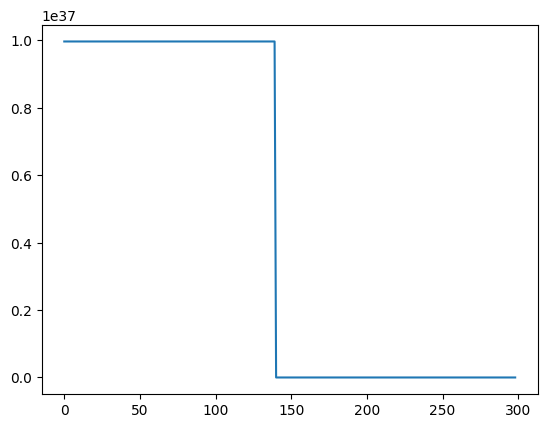

In [99]:
plt.plot(height0[0])

In [123]:
(9 - simulations[0]['Si_max_t']) == 0

np.True_

0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
0.2
1
0.2
0.2
0.2
0.2
0.2


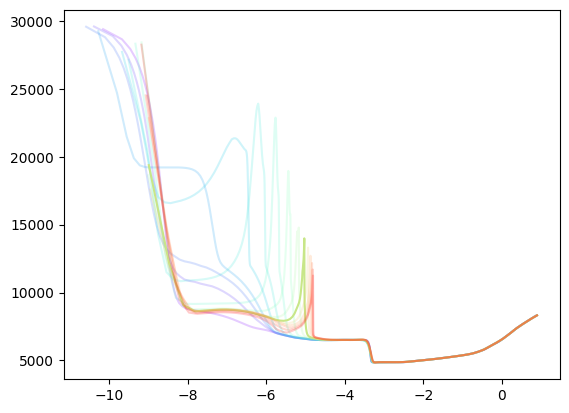

In [140]:
cmap = mpl.colormaps['rainbow']
colors = cmap(np.linspace(0, 1, 15))
ind = simulations[10]['Si_max_t']
for ind in range(15):
    alpha = 1 if (ind-simulations[10]['Si_max_t'])==0 else 0.2
    print(alpha)
    _ = plt.plot(simulations[10]['log_tau_500'][ind], simulations[10]['temperature'][ind], 
                color=colors[ind], alpha=alpha)
    

In [67]:
fp

<_io.BufferedWriter name='/Users/khcho/Desktop/IRIS-moss-main/simulation/simulations.pickle'>

In [47]:
aa, bb

([False, False, False, False], [True, True, False, False])

In [39]:
'time' in 'timet'

True

In [234]:
si_data['sp_time'].shape, si_data['wvl'].shape

((601, 308), (308,))

In [251]:
idx_siwv = (si_data.wvl > 1400.77) & (si_data.wvl < 1404.77)

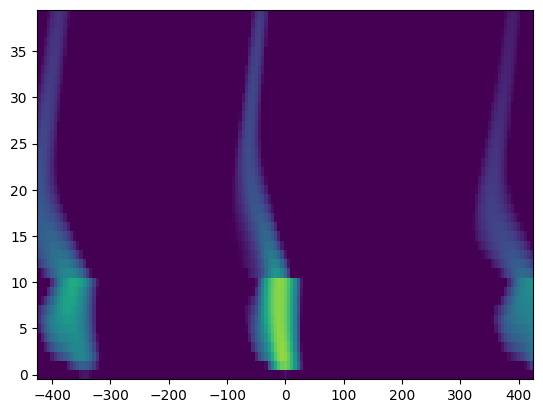

In [252]:
plt.pcolormesh((si_data.wvl[idx_siwv]-1402.77)/1402.77*3e5, si_data['time'][0:40], np.log10(si_data.sp_time[0:40, idx_siwv]), vmin=-1, vmax=4)

In [ ]:
wv = np.array(ray['wavelength'])

intensity = np.squeeze(ray['intensity'])

idx = (wv > 279.5) & (wv < 280.5)

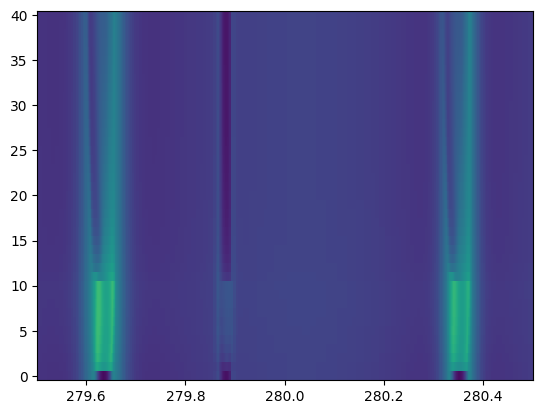

In [249]:
plt.pcolormesh(wv[idx], np.arange(41), np.log10(intensity[:, idx]), vmin=-10, vmax=-6)

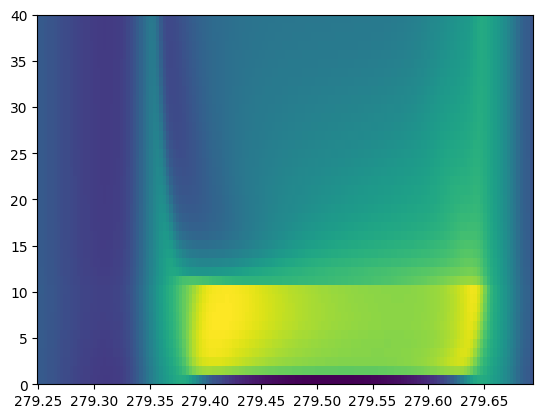

In [203]:
plt.imshow(np.squeeze(np.log10(ray['intensity'][:, 0, 250:400])), extent=[wv[250], wv[400], 0, 40])

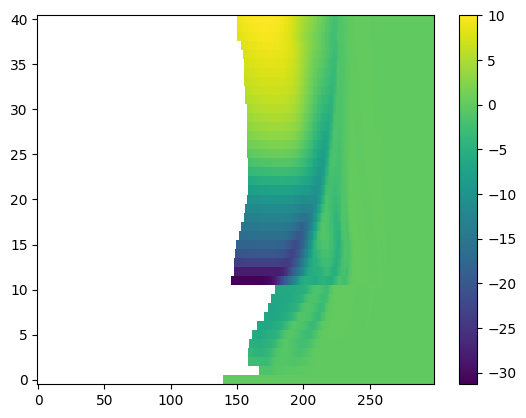

In [131]:
dum = plt.imshow(velocity_z*1e-3)
plt.gcf().colorbar(dum)

In [126]:
ray.keys()

<KeysViewHDF5 ['nx', 'ny', 'nz', 'nwave', 'wavelength_selected', 'intensity', 'tau_one_height', 'chi', 'source_function', 'Jlambda', 'scattering', 'wavelength', 'wavelength_indices']>

In [2]:
import h5py
sim_data = h5py.File("/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_5kev_plage/output/output_indata.ncdf", 'r')

In [3]:
ray = h5py.File("/Users/khcho/Desktop/IRIS-moss-main/simulation/rh_output_kh/15Mm_1MK_5kev_plage/output/output_ray.ncdf", 'r')

In [4]:
ray.keys()

<KeysViewHDF5 ['nx', 'ny', 'nz', 'nwave', 'wavelength_selected', 'intensity', 'tau_one_height', 'chi', 'source_function', 'Jlambda', 'scattering', 'wavelength', 'wavelength_indices']>

In [5]:
wavelength_indices = np.array(ray['wavelength_indices'])
wavelength_selected = np.array(ray['wavelength'])[wavelength_indices]
wavelength_selected

array([279.50622627, 279.51628586, 279.52549798, 279.53393554,
       279.54166519, 279.54874785, 279.5552392 , 279.55620945,
       279.5611901 , 279.56664706, 279.57165259, 279.57624552,
       279.58046137, 279.58433257, 279.58788879, 279.59115713,
       279.59416235, 279.5969271 , 279.59947207, 279.60181617,
       279.60397669, 279.60596942, 279.60780879, 279.60950802,
       279.61107914, 279.6125332 , 279.61388025, 279.61512952,
       279.6162894 , 279.6173676 , 279.61837114, 279.61930644,
       279.62017938, 279.62099533, 279.62175918, 279.62247542,
       279.62314815, 279.62354828, 279.62378111, 279.62437772,
       279.62494112, 279.62547415, 279.62597943, 279.62645935,
       279.6269161 , 279.62735165, 279.62776785, 279.62816635,
       279.62854868, 279.62891623, 279.62927027, 279.62961196,
       279.62994237, 279.63026246, 279.63057313, 279.63087518,
       279.63116936, 279.63145634, 279.63173674, 279.63201114,
       279.63228004, 279.63254392, 279.63280321, 279.63

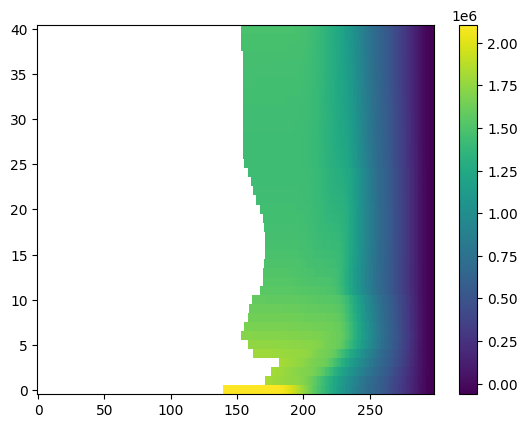

In [46]:
height0 = np.array((sim_data['atmos']['height']))[:, 0, :]
height = np.where(height0 > 1e36, np.nan, height0)
height1 = np.copy(height0)
for i, he in enumerate(height1):
    h_real = height0[i][height[i] < 1e36]
    height1[i] = np.where(height0[i] > 1e36, 2*h_real[0]-h_real[1], height0[i])
p01 = plt.imshow(np.squeeze(height))
plt.gcf().colorbar(p01)

In [49]:
idx_500 = np.argmin(abs(wavelength_selected - 500))
idx_500

np.int64(346)

In [50]:
chi_500 = np.array(ray['chi'])[:, 0, :, idx_500]
chi_500.shape

(41, 299)

In [86]:
from scipy import integrate
tau_500 = integrate.cumulative_trapezoid(chi_500, x=-height1, initial=0)
# tau_500 = np.hstack([np.full(chi_500.shape[0], 0)[:, None], tau_500])
log_tau_500 = np.log10(tau_500)

/var/folders/1n/h1tn4xf511bdd_rqlgcl4kqw000mt3/T/ipykernel_23775/3854004516.py:4: RuntimeWarning: divide by zero encountered in log10
  log_tau_500 = np.log10(tau_500)


In [66]:
temperature = sim_data['atmos']['temperature'][:, 0, :]
temperature = np.where(temperature > 1e35, np.nan, temperature)

[Text(0.5, 0, '$\\log \\tau_{500}$'), Text(0, 0.5, 'Height (km)')]

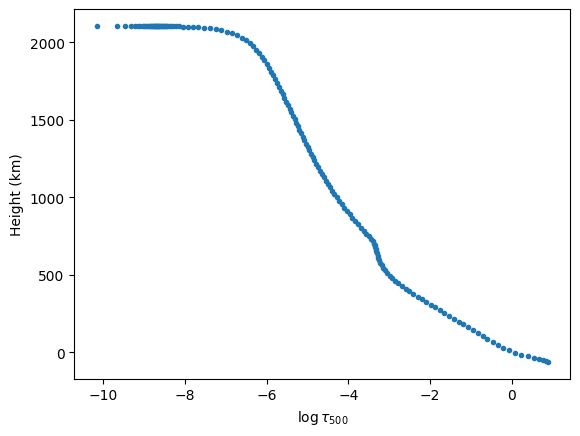

In [105]:
plt.plot(log_tau_500[0], height[0]*1e-3, '.')
plt.gca().set(xlabel=r'$\log \tau_{500}$', ylabel='Height (km)')
# plt.plot(plt.gca().get_xlim(), [0]*2)
# plt.gca().set(xlim=[-10, -1])

[Text(0, 0.5, 'Temperature (K)'), Text(0.5, 0, '$\\log \\tau_{500}$')]

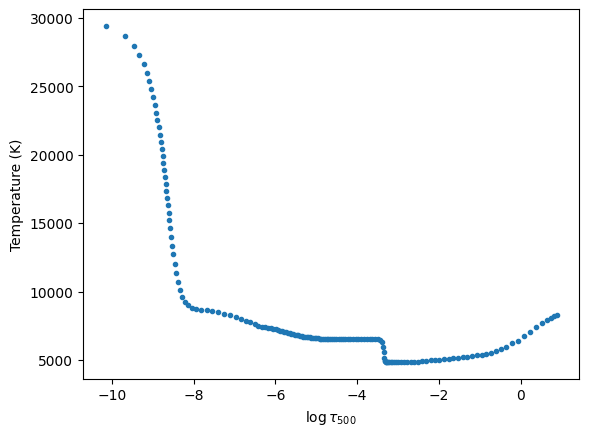

In [106]:
plt.plot(log_tau_500[0], temperature[0], '.')
plt.gca().set(ylabel=r'Temperature (K)', xlabel=r'$\log \tau_{500}$')
# plt.plot(plt.gca().get_xlim(), [0]*2)
# plt.gca().set(xlim=[-10, -1])

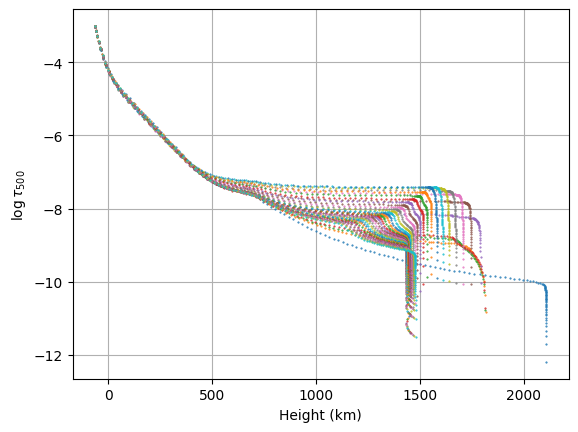

In [141]:
for i in range(40):
    plt.plot(height[i], log_tau_500[i], '.', ms=1)
plt.gca().set(xlabel='Height (km)', ylabel=r'$\log \tau_{500}$')
plt.grid()

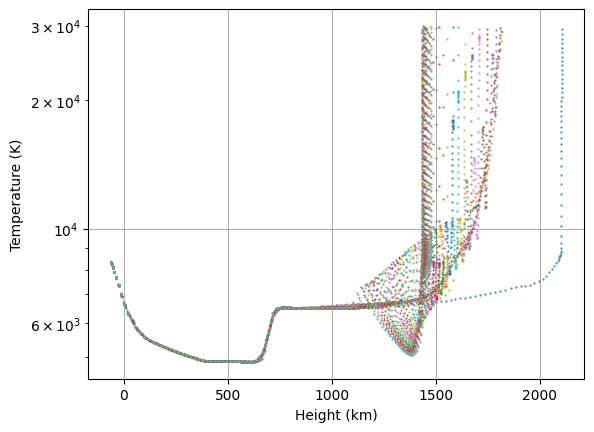

In [143]:
for i in range(40):
    plt.plot(height[i], temperature[i], '.', ms=1)
plt.gca().set(xlabel='Height (km)', ylabel='Temperature (K)', yscale='log')
plt.grid()

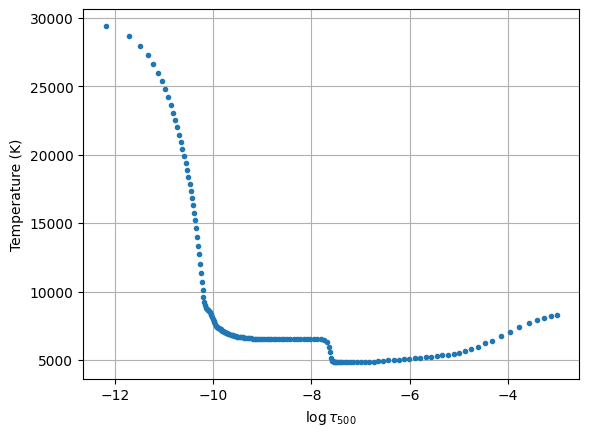

In [139]:
plt.plot(log_tau_500[0], temperature[0], '.')
plt.gca().set(xlabel=r'$\log \tau_{500}$', ylabel='Temperature (K)')
plt.grid()

In [103]:
np.sum(chi, axis=1)

array([0.00110751, 0.00109956, 0.00108148, 0.00106479, 0.00105759,
       0.0010482 , 0.00104856, 0.0010527 , 0.00105798, 0.00106185,
       0.00106585, 0.00107937, 0.00108038, 0.0010787 , 0.00107602,
       0.001074  , 0.00107221, 0.00107137, 0.00107056, 0.00107029,
       0.00107041, 0.00107092, 0.00107126, 0.00107083, 0.00107097,
       0.0010759 , 0.00107678, 0.00107748, 0.00107783, 0.00107729,
       0.00107736, 0.0010779 , 0.00107858, 0.00107914, 0.00107988,
       0.00108068, 0.00108128, 0.00108194, 0.00108267, 0.00108342,
       0.00108406], dtype=float32)

In [72]:
for key in list(sim_data.keys()):
    print(f'{key}, {np.array(sim_data[key]).shape}')
    try:
        for key_ in list(sim_data[key].keys()):
            print(f'    {key_}, {np.array(sim_data[key][key_]).shape}')
    except:
        pass

input, (0,)
atmos, (13,)
    nhydr, (6,)
    nelements, (99,)
    nrays, (5,)
    temperature, (41, 1, 299)
    velocity_z, (41, 1, 299)
    height, (41, 1, 299)
    element_weight, (99,)
    element_abundance, (99,)
    element_id, (99, 30)
    muz, (5,)
    wmu, (5,)
    x, (41,)
    y, (1,)
mpi, (15,)
    nprocesses, (4,)
    niterations, (1500,)
    xnum, (41,)
    ynum, (1,)
    task_map, (41, 1)
    task_number, (41, 1)
    iterations, (41, 1)
    convergence, (41, 1)
    delta_max, (41, 1)
    z_cut, (41, 1)
    ntasks, (4,)
    hostname, (4, 30)
    starting_time, (4, 30)
    finish_time, (4, 30)
    delta_max_history, (41, 1, 1500)
nx, (41,)
ny, (1,)
nz, (299,)
strlen, (30,)


In [66]:
for key in list(sim_data['atmos'].keys()):
    print(f'{key}, {np.array(sim_data['atmos'][key]).shape}')

nhydr, (6,)
nelements, (99,)
nrays, (5,)
temperature, (41, 1, 299)
velocity_z, (41, 1, 299)
height, (41, 1, 299)
element_weight, (99,)
element_abundance, (99,)
element_id, (99, 30)
muz, (5,)
wmu, (5,)
x, (41,)
y, (1,)
